### Zadania

Lista składa się z dwóch sekcji: pierwsza (zadania 1 i 2) dotyczy metod detekcji krawędzi, druga (zadania 3 i 4) operacji na histogramach.

In [21]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from qwlist.qwlist import QList, Lazy

##### Zad. 1: Wyznaczenie gradientów

Wykonaj dla obrazu `coins` sztuczny obraz ilustrujący wielkość (moduł) wektora gradientu w danym punkcie. Do wyświetlenia użyj [mapy kolorów](https://matplotlib.org/stable/tutorials/colors/colormaps.html) `hot` do oznaczenia wielkości gradientu odpowiednim kolorem – im większa wartość, tym bardziej czerwony (_mapa ciepła_).

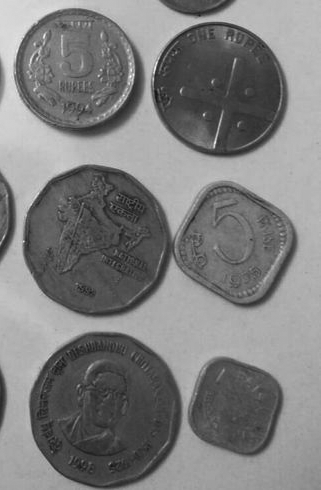

In [3]:
coins = cv2.imread('../Dane1-4/Monety_szare.bmp', cv2.IMREAD_GRAYSCALE)
Image.fromarray(coins)

Rozwiązanie:

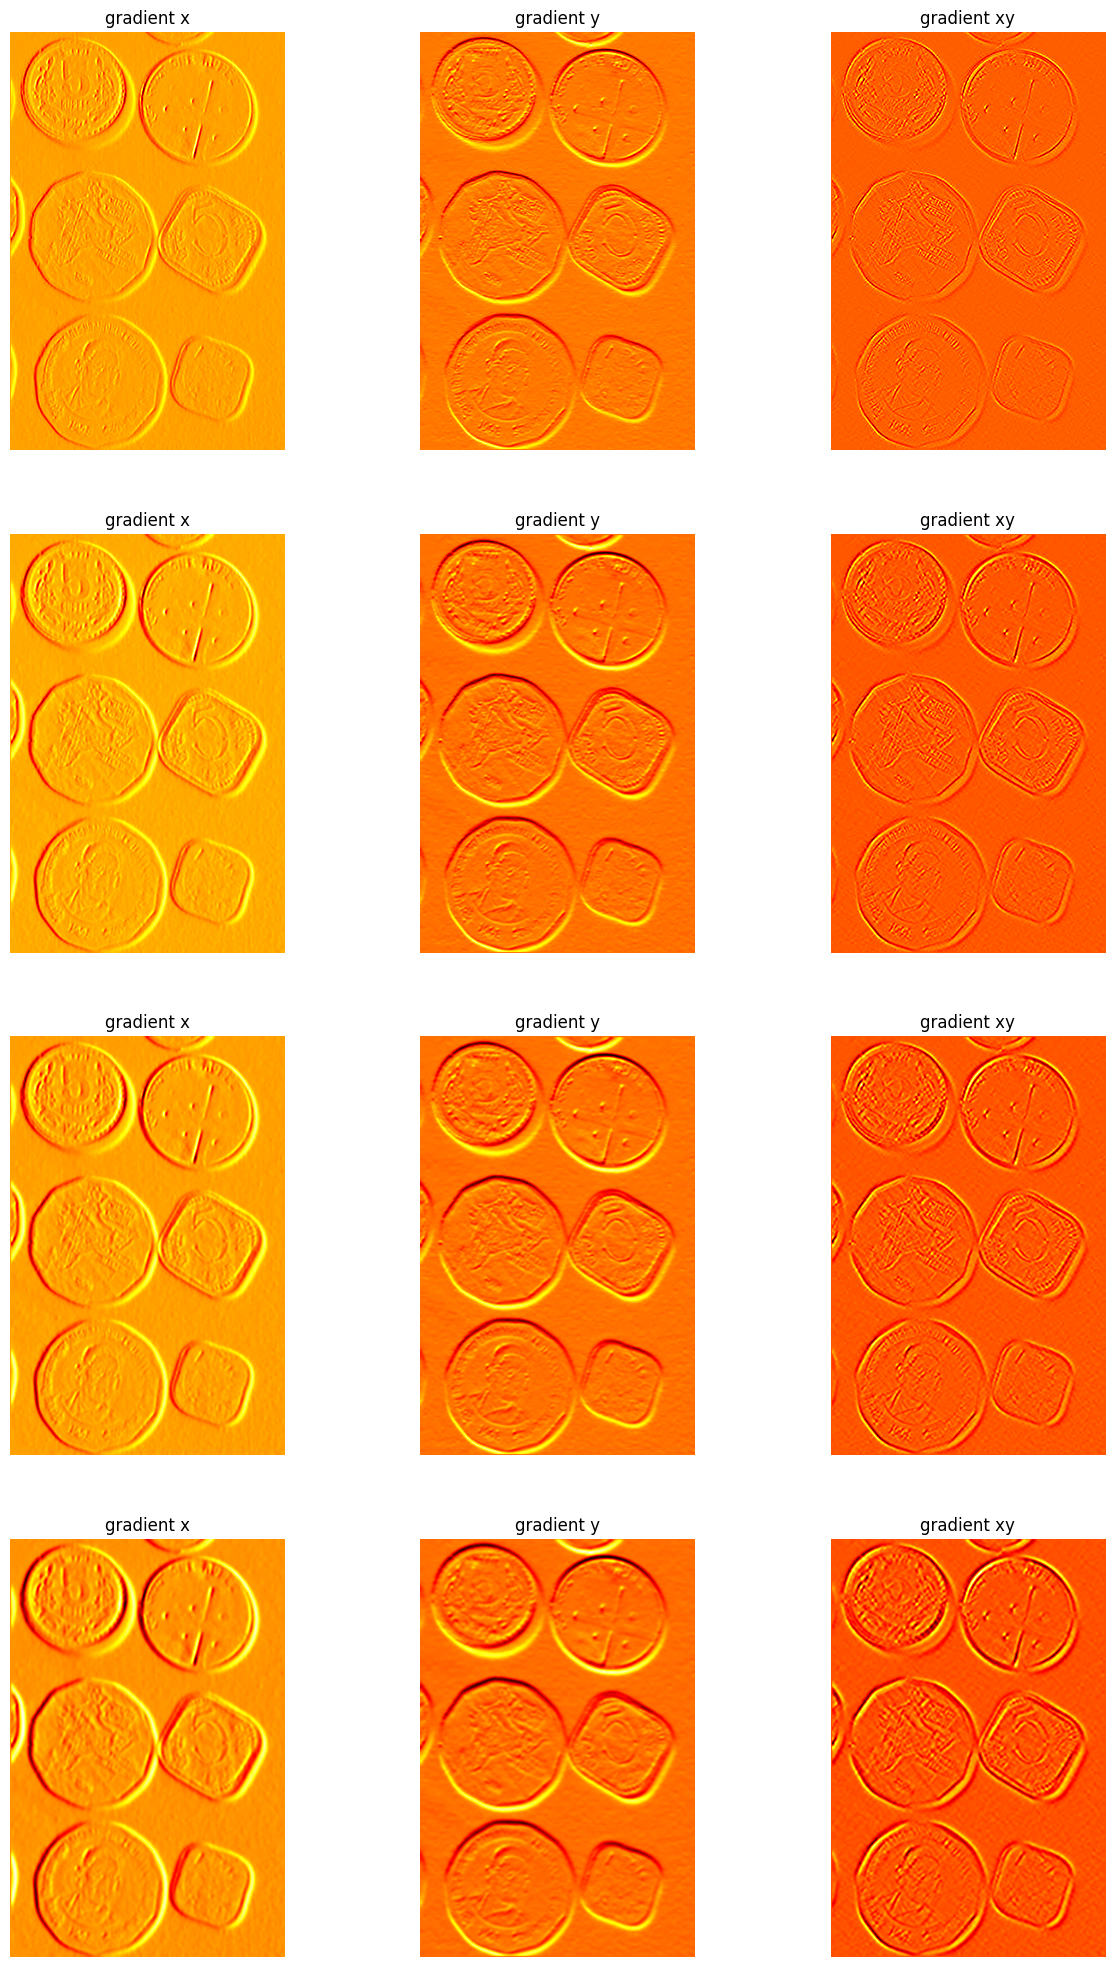

In [18]:
def plot_gradient_modulus(data, axes):
    ksize, grad_x, grad_y, grad_xy = data

    axes[0].imshow(grad_x, cmap='hot')
    axes[0].axis('off')
    axes[0].set_title('gradient x')
    axes[0].set_xlabel(f'Kernel size: {ksize}')

    axes[1].imshow(grad_y, cmap='hot')
    axes[1].axis('off')
    axes[1].set_title('gradient y')
    axes[1].set_xlabel(f'Kernel size: {ksize}')

    axes[2].imshow(grad_xy, cmap='hot')
    axes[2].axis('off')
    axes[2].set_title('gradient xy')
    axes[2].set_xlabel(f'Kernel size: {ksize}')


ksizes = [3, 5, 7, 11]
fig, axes = plt.subplots(nrows=len(ksizes), ncols=3, figsize=(15, 25))


(
    QList(ksizes)
    .map(lambda ksize: (
        ksize,
        cv2.Sobel(coins, cv2.CV_64F, 1, 0, ksize=ksize),
        cv2.Sobel(coins, cv2.CV_64F, 0, 1, ksize=ksize),
        cv2.Sobel(coins, cv2.CV_64F, 1, 1, ksize=ksize),         
    ))
    .zip(range(5))
    .foreach(lambda pair: plot_gradient_modulus(pair[0], axes[pair[1]]))
)


:TODO notatka o operatorze Sobela

---

##### Zad. 2: Detekcja krawędzi

Przeprowadź z obrazem `coins_noise` takie przekształcenia, aby zmaksymalizować możliwość rozpoznania obiektów poprzez detekcję krawędzi. Wykorzystaj filtr Canny'ego dla różnych wartości progów oraz filtry redukcji szumu.

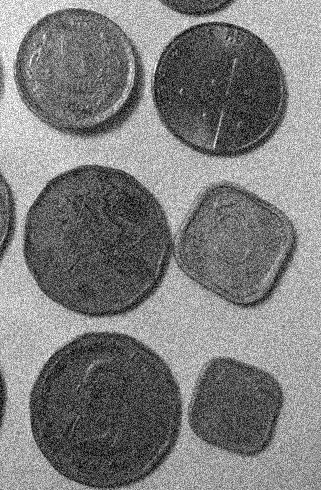

In [19]:
coins_noise = cv2.imread('../Dane1-4/Monety_szare_szum.bmp', cv2.IMREAD_GRAYSCALE)
Image.fromarray(coins_noise)

Rozwiązanie:

In [35]:
def plot_canny(data: Lazy, axes):
    def plot_axis(data, ax):
        th, d, img = data
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Thresholds: ({th}, {d})')
        ax.axis('off')

    data.zip(axes.flatten()).foreach(lambda x: plot_axis(*x))

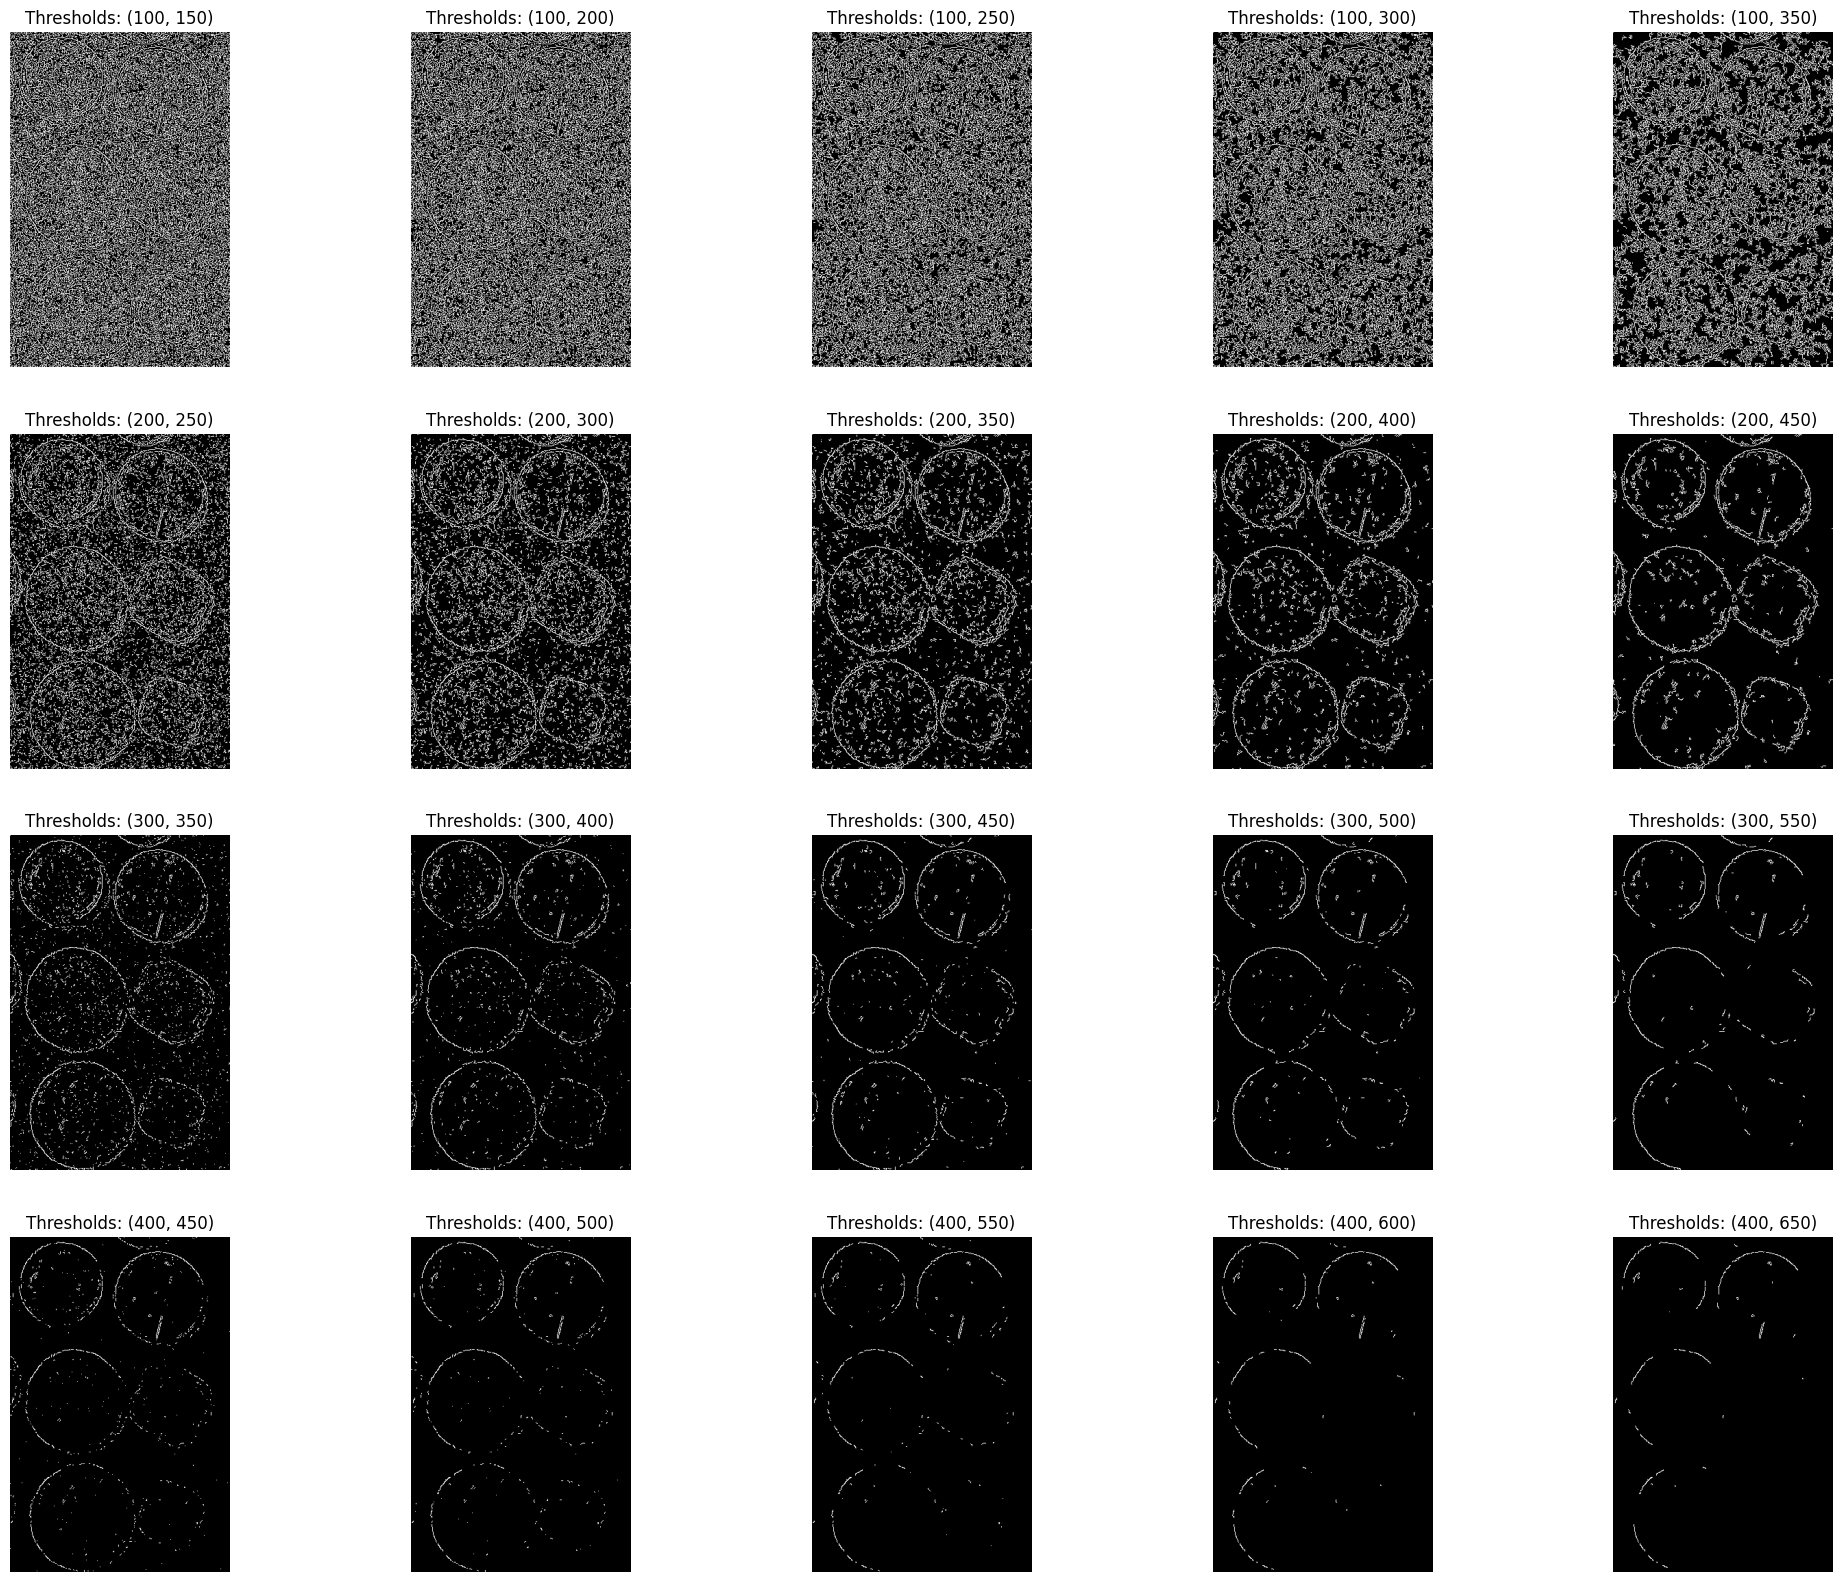

In [36]:
thresholds = [100, 200, 300, 400]
deltas = [50, 100, 150, 200, 250]
fig, axes = plt.subplots(nrows=len(thresholds), ncols=len(deltas), figsize=(5 * len(deltas), 5 * len(thresholds)))
# fig.suptitle('Bez oczyszczenia zaszumienia')

plot_canny(
    Lazy(thresholds)
    .flatmap(lambda th: [(th, th + d) for d in deltas])
    .map(lambda pair: (pair[0], pair[1], cv2.Canny(coins_noise, pair[0], pair[1]))),
    axes
)

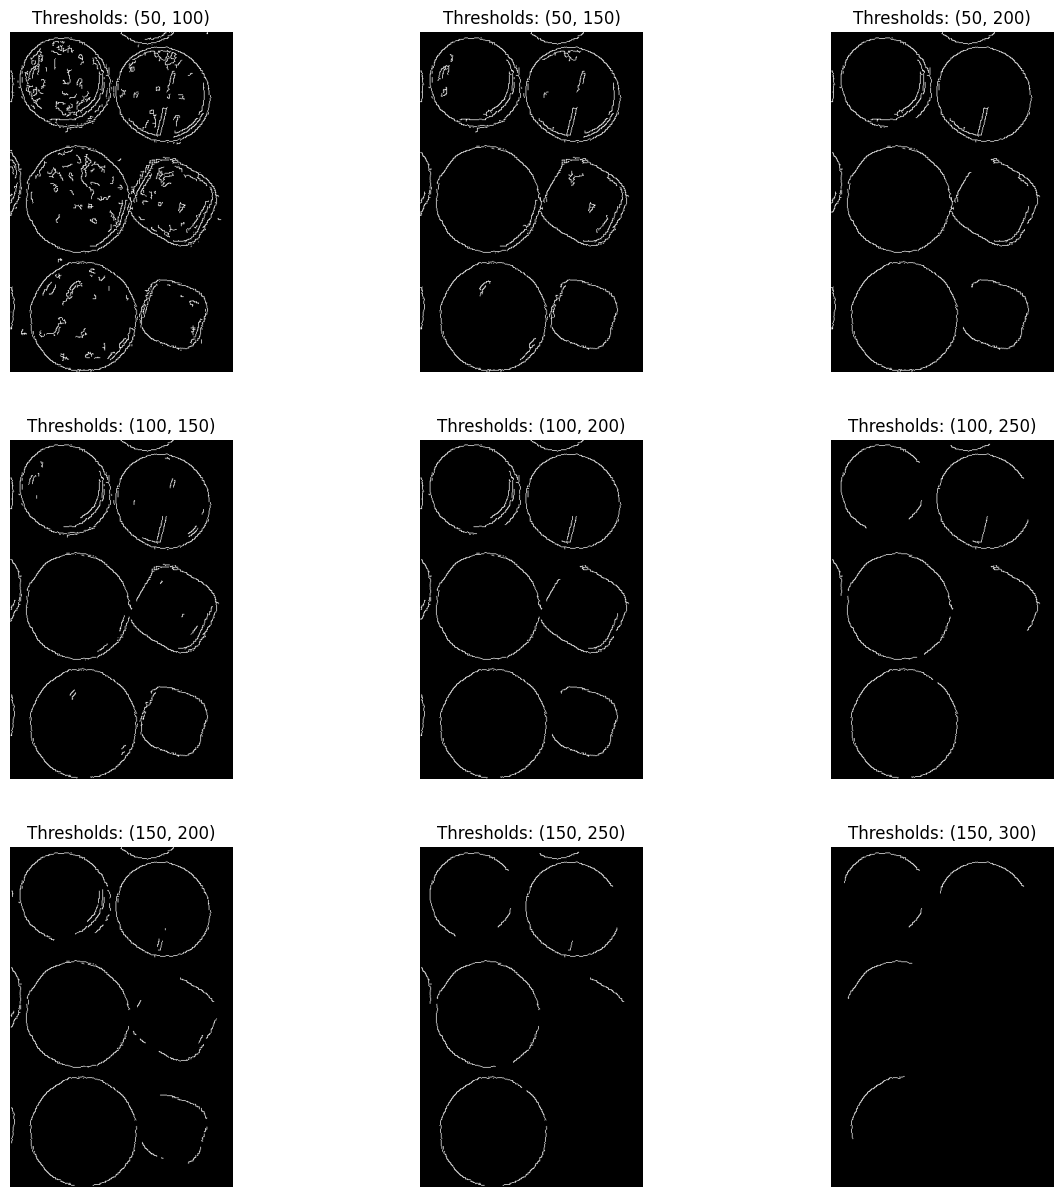

In [39]:
thresholds = [50, 100, 150]
deltas = [50, 100, 150]
fig, axes = plt.subplots(nrows=len(thresholds), ncols=len(deltas), figsize=(5 * len(deltas), 5 * len(thresholds)))

plot_canny(
    Lazy(thresholds)
    .flatmap(lambda th: [(th, th + d) for d in deltas])
    .map(lambda pair: (pair[0], pair[1], cv2.Canny(cv2.blur(coins_noise, (5, 5)), pair[0], pair[1]))),
    axes
)

---

##### Zad. 3: Wyrównanie histogramu

Wyrównaj histogram obrazu `coins_noise`. Wyniki zaprezentuj za pomocą obrazów i towarzyszących im histogramów.

(-0.5, 320.5, 489.5, -0.5)

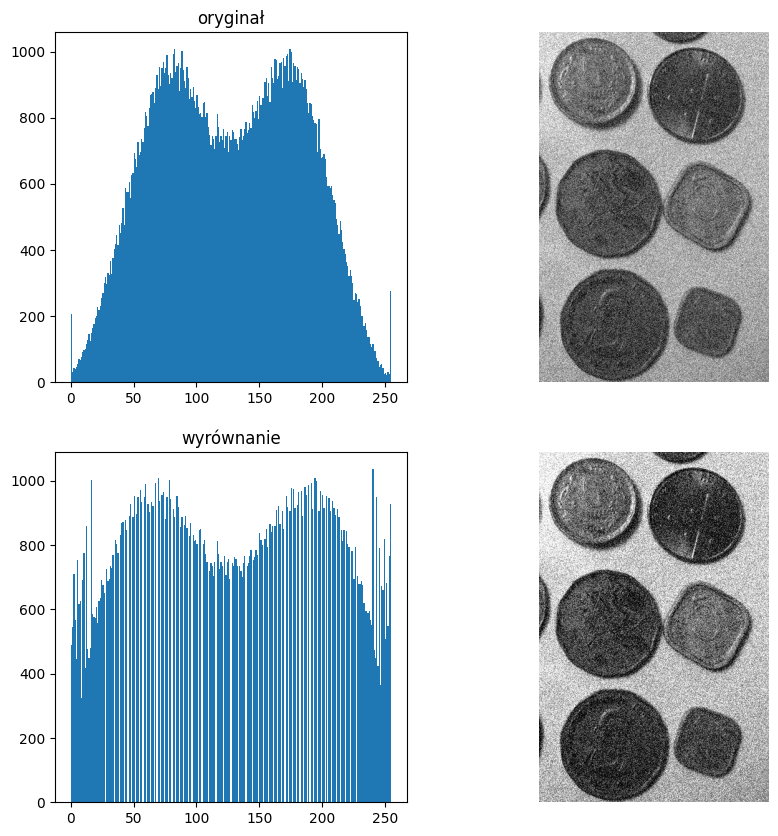

In [47]:
# Zwykłe wyrównanie histogramu
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0][0].hist(coins_noise.flatten(), bins=255)
axes[0][0].set_title('oryginał')
axes[0][1].imshow(coins_noise, cmap='gray')
axes[0][1].axis('off')

equlized = cv2.equalizeHist(coins_noise)
axes[1][0].hist(equlized.flatten(), bins=255)
axes[1][0].set_title('wyrównanie')
axes[1][1].imshow(equlized, cmap='gray')
axes[1][1].axis('off')

(-0.5, 320.5, 489.5, -0.5)

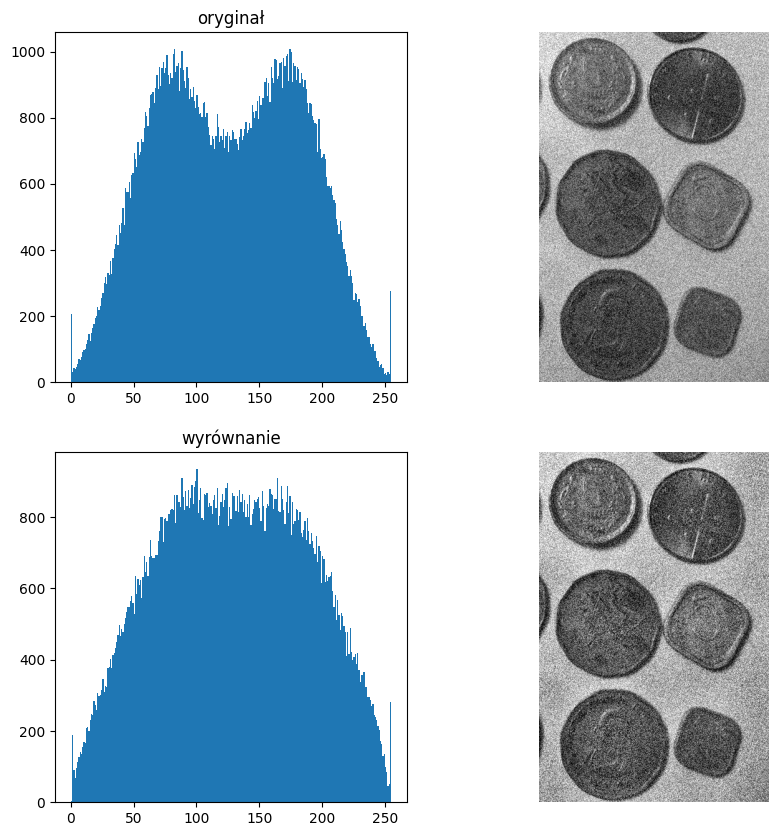

In [56]:
# CLAHE
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0][0].hist(coins_noise.flatten(), bins=255)
axes[0][0].set_title('oryginał')
axes[0][1].imshow(coins_noise, cmap='gray')
axes[0][1].axis('off')

clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(7, 7))
equlized = clahe.apply(coins_noise)
axes[1][0].hist(equlized.flatten(), bins=255)
axes[1][0].set_title('wyrównanie')
axes[1][1].imshow(equlized, cmap='gray')
axes[1][1].axis('off')

---

##### Zad. 4: Transformacja do rozkładu docelowego

Dla obrazów `hare_gray` i `hare_color` wykonaj transformacje na składowych S i/lub V modelu HSV, przechodząc do wybranego (założonego) rozkładu docelowego, tak aby zmaksymalizować możliwość wyodrębnienia obiektu z otoczenia (zająca) przy użyciu algorytmu binaryzacji Otsu.

Podpowiedź: przedstawiona we wstępie teoretycznym transformacja obu rozkładów (źródłowego i docelowego) do rozkładu jednostajnego _nie musi_ zostać faktycznie wykonana (dlatego nie używaj w zadaniu funkcji `cv2.equalizeHist`)! Wystarczy porównywanie ze sobą wartości ze skumulowanych rozkładów (rysunek 3).

Podpowiedź 2: [cv2.LUT](https://docs.opencv.org/4.5.3/d2/de8/group__core__array.html#gab55b8d062b7f5587720ede032d34156f)

**4A** (`hare_gray`):

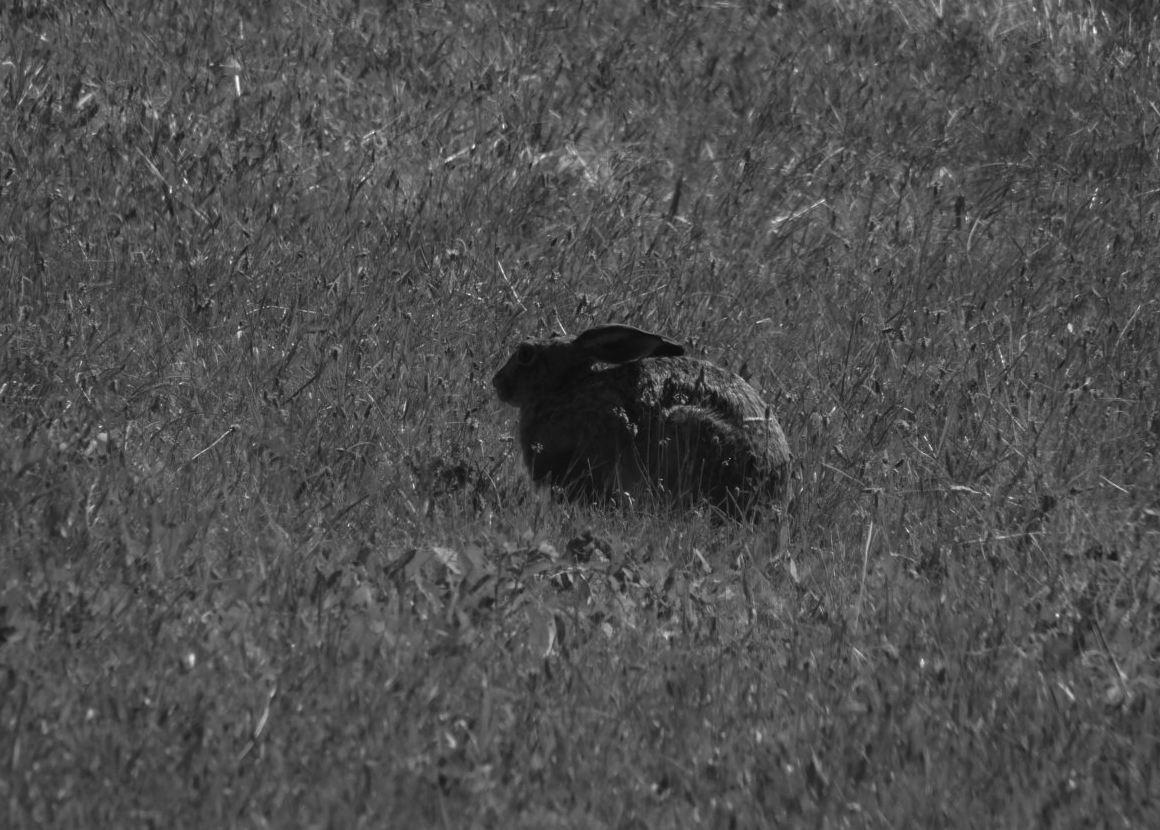

In [69]:
hare_gray = cv2.imread('../Dane1-4/Zajac.jpg', cv2.IMREAD_GRAYSCALE)
Image.fromarray(hare_gray)

In [205]:
def gaussians(means, stds, mixing_coefs) -> np.ndarray:
    assert sum(mixing_coefs) == 1, "mixing coefficients do not sum up to 1.0"

    target =  np.concatenate(
        QList(means)
        .zip(stds)
        .zip(mixing_coefs)
        .map(lambda x: (x[0][0], x[0][1], x[1]))
        .map(lambda x: np.random.normal(x[0], x[1], int(x[2] * 100_000)))
        .collect()
    )
    return np.rint(255 * (target - target.min()) / target.ptp()).astype(np.uint8)

def make_lookup_tabe(src, dst):
    src_hist = cv2.calcHist(src.reshape(1, -1), [0], None, [256], [0, 255])
    src_dist = 255 * np.cumsum(src_hist) / src.size

    dst_hist = cv2.calcHist(dst.reshape(1, -1), [0], None, [256], [0, 255])
    dst_dist = 255 * np.cumsum(dst_hist) / dst.size

    lut = np.argmin(np.abs(dst_dist.reshape(1, -1) - src_dist.reshape(-1, 1)), axis=1)

    lut_hist = cv2.calcHist(lut[None, ...].astype(np.uint8), [0], None, [256], (0, 256), accumulate=False)
    lut_dist = 255 * np.cumsum(lut_hist) / lut.size

    return lut, src_dist, dst_dist, lut_dist

In [247]:
def plot_dist_change(src, means, stds, mixing_coefs):
    dst = gaussians(means, stds, mixing_coefs)

    lut, src_dist, dst_dist, lut_dist = make_lookup_tabe(src, dst)

    # OTSU
    out = cv2.LUT(hare_gray, lut).astype(np.uint8)
    lut_th, out_lut = cv2.threshold(out, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    src_th, out_src = cv2.threshold(hare_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Histogramy
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    ax = axes[0]
    ax.set_title('obraz oryginalny')
    ax.hist(hare_gray.flatten(), bins=256)
    ax.axvline(x=src_th, color='r', label=f'otsu threshold = {src_th}')
    ax.grid()
    ax.legend()

    ax = axes[1]
    ax.set_title('target')
    ax.hist(dst.flatten(), bins=256)
    ax.grid()

    ax = axes[2]
    ax.set_title('obraz docelowy')
    ax.hist(out.flatten(), bins=256)
    ax.axvline(x=lut_th, color='r', label=f'otsu threshold = {lut_th}')
    ax.grid()
    ax.legend()

    plt.show()

    # Dystrybuanty
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    ax.set_title('Dystrybuanty')
    ax.plot(src_dist, label='oruginalna')
    ax.plot(dst_dist, label='docelowa')
    ax.plot(lut_dist, label='otrzymana')
    ax.legend();

    plt.show()

    # Obrazy
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    axes[0][0].imshow(src, cmap='gray')
    axes[0][0].axis('off')
    axes[0][0].set_title('Obraz oryginalny')

    axes[0][1].imshow(src, cmap='gray')
    axes[0][1].axis('off')
    axes[0][1].set_title('Obraz oryginalny')
    
    plt.show()

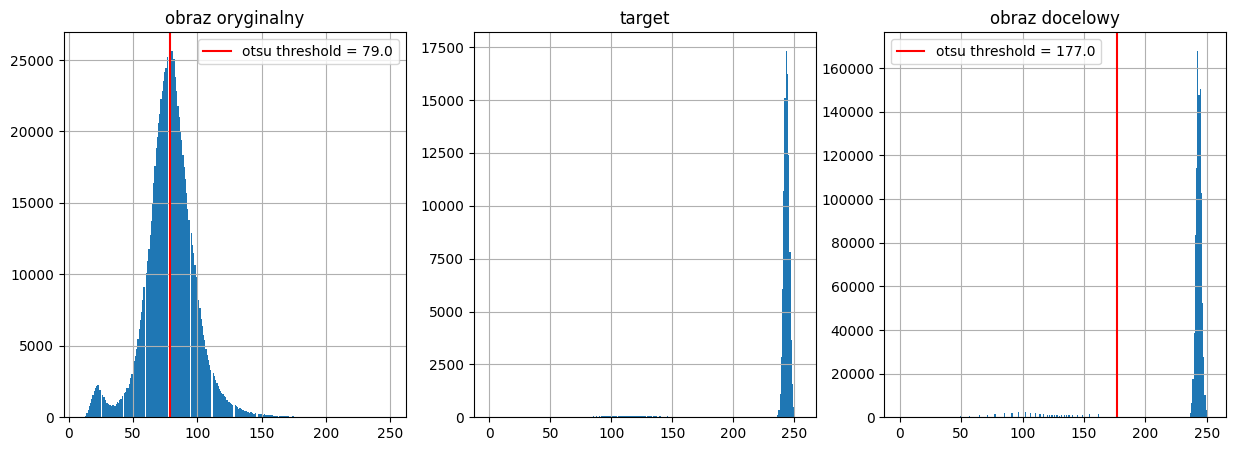

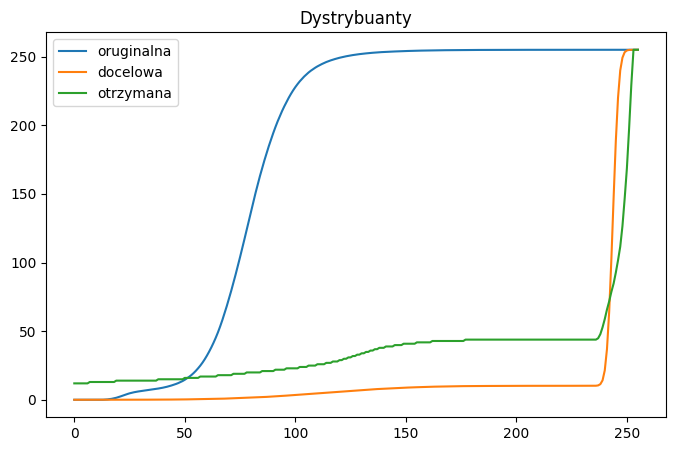

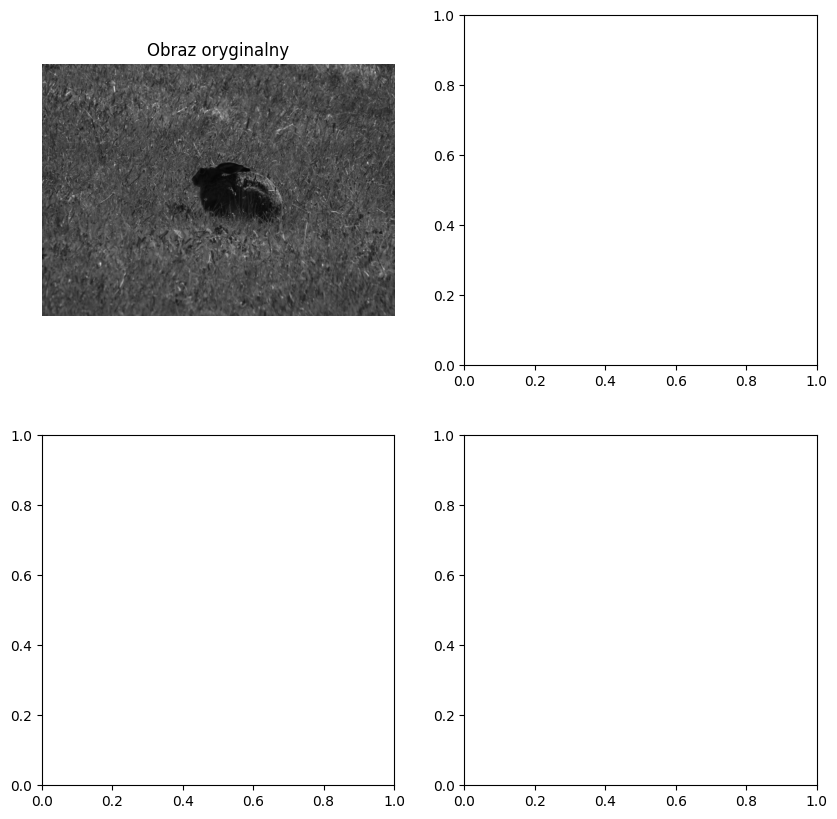

In [248]:
plot_dist_change(hare_gray, [-3, 3], [1.5, 0.1], [0.04, 0.96])

In [227]:
dst = gaussians([-3, 3], [1.5, 0.1], [0.04, 0.96])

lut, src_dist, dst_dist, lut_dist = make_lookup_tabe(hare_gray, dst)

# OTSU
out = cv2.LUT(hare_gray, lut).astype(np.uint8)
lut_th, out_lut = cv2.threshold(out, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
src_th, out_src = cv2.threshold(hare_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


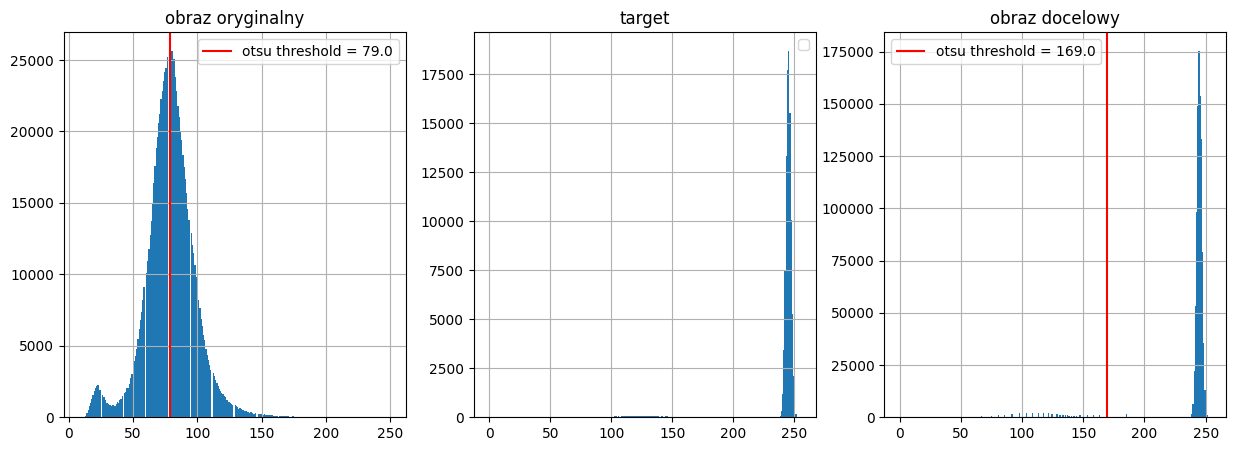

In [230]:
# Histogramy
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax = axes[0]
ax.set_title('obraz oryginalny')
ax.hist(hare_gray.flatten(), bins=256)
ax.axvline(x=src_th, color='r', label=f'otsu threshold = {src_th}')
ax.grid()
ax.legend()

ax = axes[1]
ax.set_title('target')
ax.hist(dst.flatten(), bins=256)
ax.grid()
ax.legend()

ax = axes[2]
ax.set_title('obraz docelowy')
ax.hist(out.flatten(), bins=256)
ax.axvline(x=lut_th, color='r', label=f'otsu threshold = {lut_th}')
ax.grid()
ax.legend();

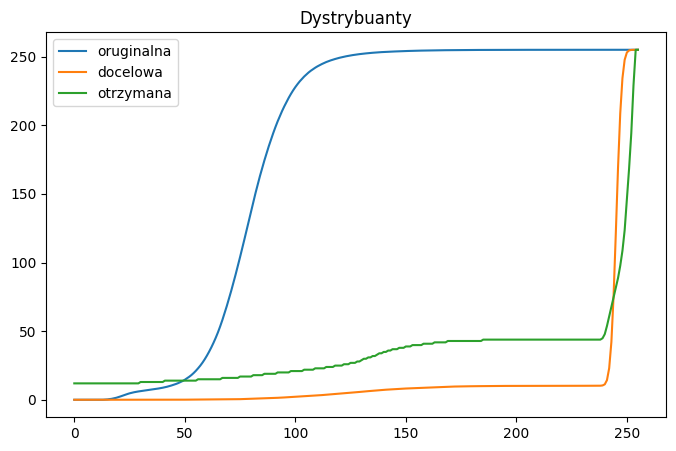

In [231]:
# Dystrybuanty
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.set_title('Dystrybuanty')
ax.plot(src_dist, label='oruginalna')
ax.plot(dst_dist, label='docelowa')
ax.plot(lut_dist, label='otrzymana')
ax.legend();

Rozwiązanie:

---

**4B** (`hare_color`):

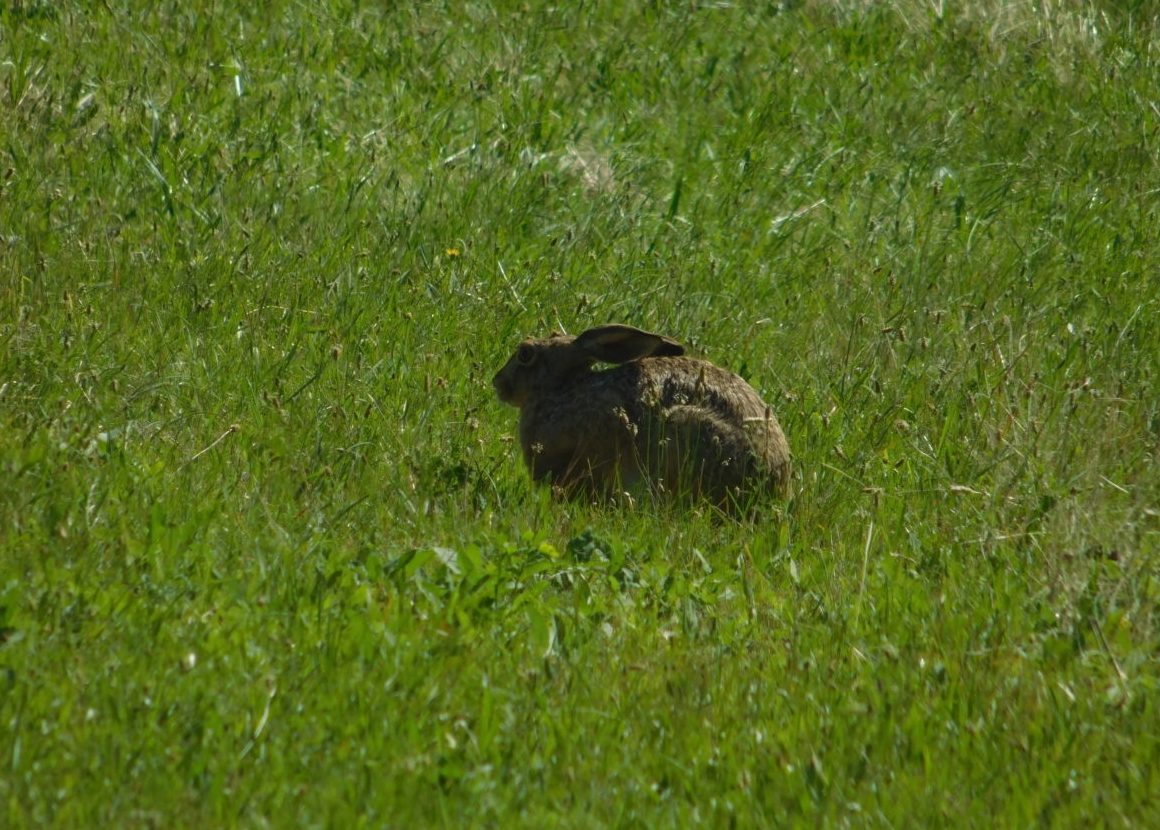

In [6]:
hare_color = cv2.imread('Zajac_kolor.jpg')
Image.fromarray(hare_color[..., ::-1])

Rozwiązanie: